# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.34KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

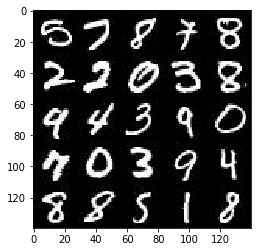

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

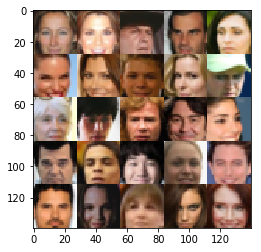

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha=0.01
    
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    alpha=0.9
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.5581... Generator Loss: 10.7433
Epoch 1/2... Batch 20... Discriminator Loss: 0.8408... Generator Loss: 1.7077
Epoch 1/2... Batch 30... Discriminator Loss: 0.8703... Generator Loss: 3.5215
Epoch 1/2... Batch 40... Discriminator Loss: 0.7683... Generator Loss: 2.6665
Epoch 1/2... Batch 50... Discriminator Loss: 3.6843... Generator Loss: 11.2707
Epoch 1/2... Batch 60... Discriminator Loss: 0.6643... Generator Loss: 1.9188
Epoch 1/2... Batch 70... Discriminator Loss: 0.8058... Generator Loss: 1.9188
Epoch 1/2... Batch 80... Discriminator Loss: 0.8280... Generator Loss: 1.8122
Epoch 1/2... Batch 90... Discriminator Loss: 2.1603... Generator Loss: 4.0949
Epoch 1/2... Batch 100... Discriminator Loss: 0.9507... Generator Loss: 1.3827


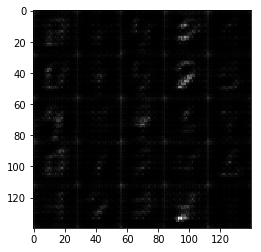

Epoch 1/2... Batch 110... Discriminator Loss: 1.3238... Generator Loss: 1.5110
Epoch 1/2... Batch 120... Discriminator Loss: 1.1264... Generator Loss: 1.0468
Epoch 1/2... Batch 130... Discriminator Loss: 1.6416... Generator Loss: 0.3789
Epoch 1/2... Batch 140... Discriminator Loss: 1.1252... Generator Loss: 1.0169
Epoch 1/2... Batch 150... Discriminator Loss: 1.0852... Generator Loss: 1.1420
Epoch 1/2... Batch 160... Discriminator Loss: 1.1004... Generator Loss: 1.7418
Epoch 1/2... Batch 170... Discriminator Loss: 1.2264... Generator Loss: 0.8335
Epoch 1/2... Batch 180... Discriminator Loss: 2.0723... Generator Loss: 0.2596
Epoch 1/2... Batch 190... Discriminator Loss: 1.3296... Generator Loss: 0.9383
Epoch 1/2... Batch 200... Discriminator Loss: 1.4975... Generator Loss: 2.1983


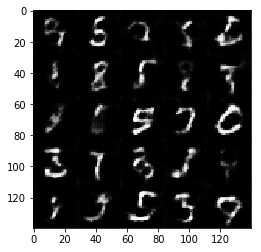

Epoch 1/2... Batch 210... Discriminator Loss: 1.2651... Generator Loss: 0.8210
Epoch 1/2... Batch 220... Discriminator Loss: 1.3155... Generator Loss: 1.3891
Epoch 1/2... Batch 230... Discriminator Loss: 1.0694... Generator Loss: 1.0327
Epoch 1/2... Batch 240... Discriminator Loss: 1.5969... Generator Loss: 0.4048
Epoch 1/2... Batch 250... Discriminator Loss: 1.1726... Generator Loss: 1.2619
Epoch 1/2... Batch 260... Discriminator Loss: 1.2080... Generator Loss: 0.9476
Epoch 1/2... Batch 270... Discriminator Loss: 1.5134... Generator Loss: 0.4363
Epoch 1/2... Batch 280... Discriminator Loss: 1.1631... Generator Loss: 0.8470
Epoch 1/2... Batch 290... Discriminator Loss: 1.3346... Generator Loss: 1.7321
Epoch 1/2... Batch 300... Discriminator Loss: 1.5091... Generator Loss: 0.4390


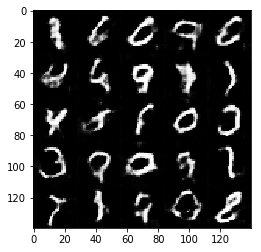

Epoch 1/2... Batch 310... Discriminator Loss: 1.3338... Generator Loss: 0.5770
Epoch 1/2... Batch 320... Discriminator Loss: 1.1909... Generator Loss: 0.9253
Epoch 1/2... Batch 330... Discriminator Loss: 1.8954... Generator Loss: 2.2514
Epoch 1/2... Batch 340... Discriminator Loss: 1.2311... Generator Loss: 0.8268
Epoch 1/2... Batch 350... Discriminator Loss: 1.1731... Generator Loss: 0.9440
Epoch 1/2... Batch 360... Discriminator Loss: 1.1312... Generator Loss: 1.2860
Epoch 1/2... Batch 370... Discriminator Loss: 1.1808... Generator Loss: 0.8202
Epoch 1/2... Batch 380... Discriminator Loss: 1.3327... Generator Loss: 0.6606
Epoch 1/2... Batch 390... Discriminator Loss: 1.1648... Generator Loss: 1.2579
Epoch 1/2... Batch 400... Discriminator Loss: 2.0846... Generator Loss: 0.2303


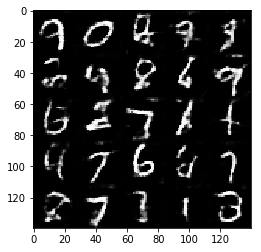

Epoch 1/2... Batch 410... Discriminator Loss: 1.2896... Generator Loss: 0.7230
Epoch 1/2... Batch 420... Discriminator Loss: 1.1682... Generator Loss: 0.9066
Epoch 1/2... Batch 430... Discriminator Loss: 1.1959... Generator Loss: 0.7083
Epoch 1/2... Batch 440... Discriminator Loss: 1.3728... Generator Loss: 0.5546
Epoch 1/2... Batch 450... Discriminator Loss: 1.1529... Generator Loss: 0.7517
Epoch 1/2... Batch 460... Discriminator Loss: 1.2687... Generator Loss: 1.0373
Epoch 2/2... Batch 10... Discriminator Loss: 1.2049... Generator Loss: 0.9285
Epoch 2/2... Batch 20... Discriminator Loss: 1.9667... Generator Loss: 2.6206
Epoch 2/2... Batch 30... Discriminator Loss: 1.1399... Generator Loss: 0.9868
Epoch 2/2... Batch 40... Discriminator Loss: 1.4297... Generator Loss: 2.0333
Epoch 2/2... Batch 50... Discriminator Loss: 1.1556... Generator Loss: 0.8564
Epoch 2/2... Batch 60... Discriminator Loss: 1.5066... Generator Loss: 2.0947
Epoch 2/2... Batch 70... Discriminator Loss: 1.1547... Gen

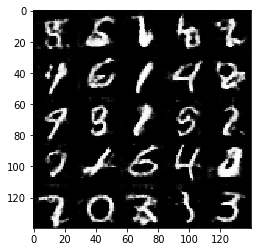

Epoch 2/2... Batch 110... Discriminator Loss: 1.1047... Generator Loss: 0.9634
Epoch 2/2... Batch 120... Discriminator Loss: 1.2470... Generator Loss: 1.5340
Epoch 2/2... Batch 130... Discriminator Loss: 1.1726... Generator Loss: 0.7772
Epoch 2/2... Batch 140... Discriminator Loss: 1.1592... Generator Loss: 0.8636
Epoch 2/2... Batch 150... Discriminator Loss: 1.4058... Generator Loss: 0.4978
Epoch 2/2... Batch 160... Discriminator Loss: 0.9753... Generator Loss: 1.3818
Epoch 2/2... Batch 170... Discriminator Loss: 1.3785... Generator Loss: 0.5502
Epoch 2/2... Batch 180... Discriminator Loss: 1.3117... Generator Loss: 1.6205
Epoch 2/2... Batch 190... Discriminator Loss: 1.3329... Generator Loss: 0.5717
Epoch 2/2... Batch 200... Discriminator Loss: 1.0500... Generator Loss: 1.4074


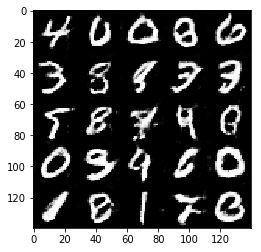

Epoch 2/2... Batch 210... Discriminator Loss: 1.1781... Generator Loss: 0.9722
Epoch 2/2... Batch 220... Discriminator Loss: 1.3088... Generator Loss: 0.6385
Epoch 2/2... Batch 230... Discriminator Loss: 1.6121... Generator Loss: 0.3976
Epoch 2/2... Batch 240... Discriminator Loss: 1.1116... Generator Loss: 1.1666
Epoch 2/2... Batch 250... Discriminator Loss: 1.6944... Generator Loss: 0.3465
Epoch 2/2... Batch 260... Discriminator Loss: 1.4574... Generator Loss: 1.8115
Epoch 2/2... Batch 270... Discriminator Loss: 1.1471... Generator Loss: 0.7434
Epoch 2/2... Batch 280... Discriminator Loss: 1.5950... Generator Loss: 0.4067
Epoch 2/2... Batch 290... Discriminator Loss: 1.1004... Generator Loss: 0.9261
Epoch 2/2... Batch 300... Discriminator Loss: 1.6390... Generator Loss: 0.3840


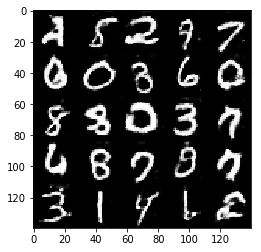

Epoch 2/2... Batch 310... Discriminator Loss: 1.1701... Generator Loss: 0.7578
Epoch 2/2... Batch 320... Discriminator Loss: 1.5247... Generator Loss: 2.1601
Epoch 2/2... Batch 330... Discriminator Loss: 1.3271... Generator Loss: 0.5932
Epoch 2/2... Batch 340... Discriminator Loss: 1.2574... Generator Loss: 0.6770
Epoch 2/2... Batch 350... Discriminator Loss: 1.6925... Generator Loss: 0.3854
Epoch 2/2... Batch 360... Discriminator Loss: 1.3469... Generator Loss: 0.5820
Epoch 2/2... Batch 370... Discriminator Loss: 1.1355... Generator Loss: 1.4421
Epoch 2/2... Batch 380... Discriminator Loss: 1.6092... Generator Loss: 0.3938
Epoch 2/2... Batch 390... Discriminator Loss: 1.2711... Generator Loss: 0.6158
Epoch 2/2... Batch 400... Discriminator Loss: 1.3105... Generator Loss: 1.5006


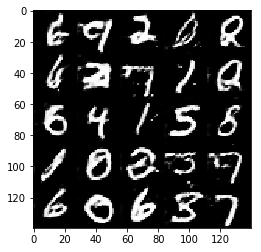

Epoch 2/2... Batch 410... Discriminator Loss: 1.2413... Generator Loss: 1.0189
Epoch 2/2... Batch 420... Discriminator Loss: 1.2063... Generator Loss: 0.7041
Epoch 2/2... Batch 430... Discriminator Loss: 1.1303... Generator Loss: 0.8552
Epoch 2/2... Batch 440... Discriminator Loss: 1.1716... Generator Loss: 0.8392
Epoch 2/2... Batch 450... Discriminator Loss: 1.0517... Generator Loss: 1.0321
Epoch 2/2... Batch 460... Discriminator Loss: 1.7341... Generator Loss: 2.5723


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.6006... Generator Loss: 17.0588
Epoch 1/1... Batch 20... Discriminator Loss: 2.6001... Generator Loss: 15.7167
Epoch 1/1... Batch 30... Discriminator Loss: 1.0206... Generator Loss: 7.2738
Epoch 1/1... Batch 40... Discriminator Loss: 1.2971... Generator Loss: 0.6533
Epoch 1/1... Batch 50... Discriminator Loss: 0.9153... Generator Loss: 1.3443
Epoch 1/1... Batch 60... Discriminator Loss: 1.6917... Generator Loss: 0.3359
Epoch 1/1... Batch 70... Discriminator Loss: 1.2559... Generator Loss: 0.7248
Epoch 1/1... Batch 80... Discriminator Loss: 1.3956... Generator Loss: 0.6957
Epoch 1/1... Batch 90... Discriminator Loss: 0.9033... Generator Loss: 1.2736
Epoch 1/1... Batch 100... Discriminator Loss: 0.9299... Generator Loss: 1.5207


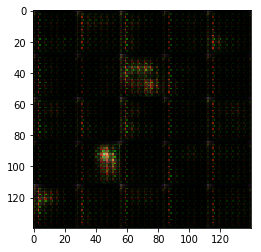

Epoch 1/1... Batch 110... Discriminator Loss: 1.5901... Generator Loss: 3.5178
Epoch 1/1... Batch 120... Discriminator Loss: 0.9265... Generator Loss: 1.4020
Epoch 1/1... Batch 130... Discriminator Loss: 0.7003... Generator Loss: 2.3515
Epoch 1/1... Batch 140... Discriminator Loss: 1.2313... Generator Loss: 2.5022
Epoch 1/1... Batch 150... Discriminator Loss: 1.3186... Generator Loss: 2.3287
Epoch 1/1... Batch 160... Discriminator Loss: 1.2133... Generator Loss: 1.6814
Epoch 1/1... Batch 170... Discriminator Loss: 1.0706... Generator Loss: 1.2139
Epoch 1/1... Batch 180... Discriminator Loss: 1.1169... Generator Loss: 1.3398
Epoch 1/1... Batch 190... Discriminator Loss: 1.1977... Generator Loss: 0.6562
Epoch 1/1... Batch 200... Discriminator Loss: 1.1033... Generator Loss: 0.9808


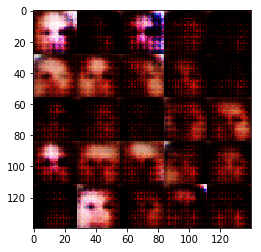

Epoch 1/1... Batch 210... Discriminator Loss: 1.1726... Generator Loss: 0.8250
Epoch 1/1... Batch 220... Discriminator Loss: 1.0254... Generator Loss: 1.6088
Epoch 1/1... Batch 230... Discriminator Loss: 2.7282... Generator Loss: 3.2060
Epoch 1/1... Batch 240... Discriminator Loss: 1.3225... Generator Loss: 0.8278
Epoch 1/1... Batch 250... Discriminator Loss: 1.3174... Generator Loss: 1.0300
Epoch 1/1... Batch 260... Discriminator Loss: 1.4538... Generator Loss: 0.6450
Epoch 1/1... Batch 270... Discriminator Loss: 0.8994... Generator Loss: 1.1933
Epoch 1/1... Batch 280... Discriminator Loss: 1.0942... Generator Loss: 0.7769
Epoch 1/1... Batch 290... Discriminator Loss: 0.7688... Generator Loss: 1.2490
Epoch 1/1... Batch 300... Discriminator Loss: 1.1277... Generator Loss: 0.7968


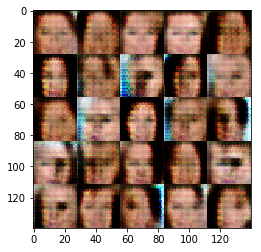

Epoch 1/1... Batch 310... Discriminator Loss: 1.4679... Generator Loss: 1.3154
Epoch 1/1... Batch 320... Discriminator Loss: 1.3128... Generator Loss: 0.7034
Epoch 1/1... Batch 330... Discriminator Loss: 1.0674... Generator Loss: 1.5638
Epoch 1/1... Batch 340... Discriminator Loss: 1.2497... Generator Loss: 1.1412
Epoch 1/1... Batch 350... Discriminator Loss: 1.1896... Generator Loss: 0.9400
Epoch 1/1... Batch 360... Discriminator Loss: 1.6719... Generator Loss: 0.3859
Epoch 1/1... Batch 370... Discriminator Loss: 1.3502... Generator Loss: 0.6040
Epoch 1/1... Batch 380... Discriminator Loss: 1.3490... Generator Loss: 0.6238
Epoch 1/1... Batch 390... Discriminator Loss: 0.9491... Generator Loss: 1.1684
Epoch 1/1... Batch 400... Discriminator Loss: 0.7902... Generator Loss: 2.0277


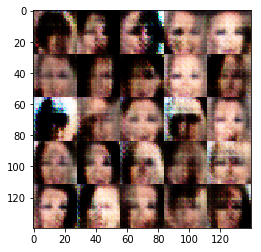

Epoch 1/1... Batch 410... Discriminator Loss: 0.9269... Generator Loss: 1.8159
Epoch 1/1... Batch 420... Discriminator Loss: 0.9788... Generator Loss: 1.2140
Epoch 1/1... Batch 430... Discriminator Loss: 0.7206... Generator Loss: 1.2708
Epoch 1/1... Batch 440... Discriminator Loss: 1.3115... Generator Loss: 0.7179
Epoch 1/1... Batch 450... Discriminator Loss: 1.2876... Generator Loss: 0.9851
Epoch 1/1... Batch 460... Discriminator Loss: 1.2363... Generator Loss: 0.9675
Epoch 1/1... Batch 470... Discriminator Loss: 1.2598... Generator Loss: 0.8309
Epoch 1/1... Batch 480... Discriminator Loss: 1.3101... Generator Loss: 0.9101
Epoch 1/1... Batch 490... Discriminator Loss: 1.2875... Generator Loss: 0.9929
Epoch 1/1... Batch 500... Discriminator Loss: 1.1090... Generator Loss: 1.2162


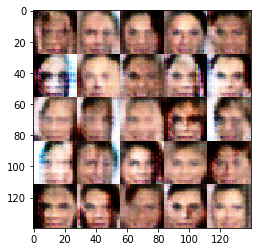

Epoch 1/1... Batch 510... Discriminator Loss: 1.1663... Generator Loss: 0.8962
Epoch 1/1... Batch 520... Discriminator Loss: 1.1281... Generator Loss: 1.1316
Epoch 1/1... Batch 530... Discriminator Loss: 0.9385... Generator Loss: 1.2391
Epoch 1/1... Batch 540... Discriminator Loss: 1.7168... Generator Loss: 2.0483
Epoch 1/1... Batch 550... Discriminator Loss: 0.7922... Generator Loss: 1.5097
Epoch 1/1... Batch 560... Discriminator Loss: 3.3526... Generator Loss: 0.0733
Epoch 1/1... Batch 570... Discriminator Loss: 1.1499... Generator Loss: 1.1935
Epoch 1/1... Batch 580... Discriminator Loss: 1.2569... Generator Loss: 0.7904
Epoch 1/1... Batch 590... Discriminator Loss: 1.3641... Generator Loss: 1.0222
Epoch 1/1... Batch 600... Discriminator Loss: 1.2220... Generator Loss: 0.6815


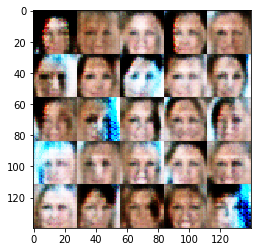

Epoch 1/1... Batch 610... Discriminator Loss: 1.4932... Generator Loss: 1.0720
Epoch 1/1... Batch 620... Discriminator Loss: 1.7162... Generator Loss: 0.3482
Epoch 1/1... Batch 630... Discriminator Loss: 1.8043... Generator Loss: 1.6999
Epoch 1/1... Batch 640... Discriminator Loss: 1.4585... Generator Loss: 0.4721
Epoch 1/1... Batch 650... Discriminator Loss: 1.4306... Generator Loss: 0.4668
Epoch 1/1... Batch 660... Discriminator Loss: 1.2148... Generator Loss: 0.7674
Epoch 1/1... Batch 670... Discriminator Loss: 1.2498... Generator Loss: 0.8591
Epoch 1/1... Batch 680... Discriminator Loss: 1.1609... Generator Loss: 2.2658
Epoch 1/1... Batch 690... Discriminator Loss: 1.0728... Generator Loss: 0.8120
Epoch 1/1... Batch 700... Discriminator Loss: 1.0840... Generator Loss: 1.0291


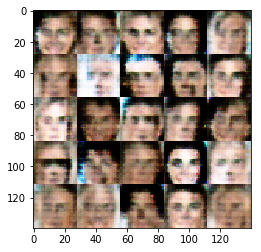

Epoch 1/1... Batch 710... Discriminator Loss: 0.9777... Generator Loss: 0.9731
Epoch 1/1... Batch 720... Discriminator Loss: 1.1056... Generator Loss: 3.3796
Epoch 1/1... Batch 730... Discriminator Loss: 1.6265... Generator Loss: 3.0781
Epoch 1/1... Batch 740... Discriminator Loss: 0.7962... Generator Loss: 1.1811
Epoch 1/1... Batch 750... Discriminator Loss: 1.2967... Generator Loss: 0.5840
Epoch 1/1... Batch 760... Discriminator Loss: 1.1757... Generator Loss: 1.9373
Epoch 1/1... Batch 770... Discriminator Loss: 0.8321... Generator Loss: 1.2021
Epoch 1/1... Batch 780... Discriminator Loss: 1.0701... Generator Loss: 1.0768
Epoch 1/1... Batch 790... Discriminator Loss: 1.5721... Generator Loss: 0.9770
Epoch 1/1... Batch 800... Discriminator Loss: 1.3612... Generator Loss: 0.9591


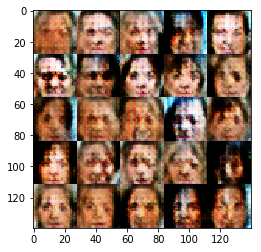

Epoch 1/1... Batch 810... Discriminator Loss: 1.1889... Generator Loss: 0.9137
Epoch 1/1... Batch 820... Discriminator Loss: 1.0458... Generator Loss: 1.3334
Epoch 1/1... Batch 830... Discriminator Loss: 1.5379... Generator Loss: 0.4166
Epoch 1/1... Batch 840... Discriminator Loss: 1.0591... Generator Loss: 1.1205
Epoch 1/1... Batch 850... Discriminator Loss: 1.1873... Generator Loss: 0.6835
Epoch 1/1... Batch 860... Discriminator Loss: 0.7361... Generator Loss: 1.6920
Epoch 1/1... Batch 870... Discriminator Loss: 1.3417... Generator Loss: 2.2942
Epoch 1/1... Batch 880... Discriminator Loss: 1.5035... Generator Loss: 0.6663
Epoch 1/1... Batch 890... Discriminator Loss: 1.4678... Generator Loss: 0.4899
Epoch 1/1... Batch 900... Discriminator Loss: 1.0719... Generator Loss: 1.0009


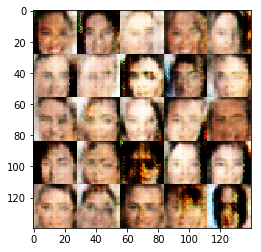

Epoch 1/1... Batch 910... Discriminator Loss: 0.8769... Generator Loss: 0.9562
Epoch 1/1... Batch 920... Discriminator Loss: 0.8898... Generator Loss: 2.0394
Epoch 1/1... Batch 930... Discriminator Loss: 1.9153... Generator Loss: 0.2809
Epoch 1/1... Batch 940... Discriminator Loss: 1.1951... Generator Loss: 1.2550
Epoch 1/1... Batch 950... Discriminator Loss: 1.4122... Generator Loss: 0.4758
Epoch 1/1... Batch 960... Discriminator Loss: 1.2410... Generator Loss: 0.9198
Epoch 1/1... Batch 970... Discriminator Loss: 1.9720... Generator Loss: 0.2942
Epoch 1/1... Batch 980... Discriminator Loss: 0.9283... Generator Loss: 1.1353
Epoch 1/1... Batch 990... Discriminator Loss: 1.2857... Generator Loss: 1.7855
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3202... Generator Loss: 1.5565


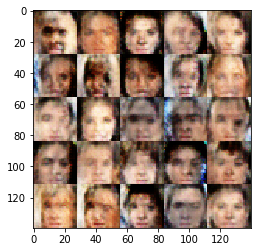

Epoch 1/1... Batch 1010... Discriminator Loss: 0.9609... Generator Loss: 0.9522
Epoch 1/1... Batch 1020... Discriminator Loss: 1.1350... Generator Loss: 0.7558
Epoch 1/1... Batch 1030... Discriminator Loss: 0.7934... Generator Loss: 1.8844
Epoch 1/1... Batch 1040... Discriminator Loss: 0.8518... Generator Loss: 1.6632
Epoch 1/1... Batch 1050... Discriminator Loss: 1.2384... Generator Loss: 0.6905
Epoch 1/1... Batch 1060... Discriminator Loss: 1.3850... Generator Loss: 0.5907
Epoch 1/1... Batch 1070... Discriminator Loss: 1.2069... Generator Loss: 0.7981
Epoch 1/1... Batch 1080... Discriminator Loss: 1.1237... Generator Loss: 1.0673
Epoch 1/1... Batch 1090... Discriminator Loss: 0.9715... Generator Loss: 0.8531
Epoch 1/1... Batch 1100... Discriminator Loss: 1.2005... Generator Loss: 0.6955


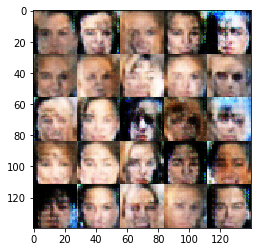

Epoch 1/1... Batch 1110... Discriminator Loss: 1.1385... Generator Loss: 0.7877
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3812... Generator Loss: 2.6756
Epoch 1/1... Batch 1130... Discriminator Loss: 1.2928... Generator Loss: 0.8004
Epoch 1/1... Batch 1140... Discriminator Loss: 1.1955... Generator Loss: 1.3297
Epoch 1/1... Batch 1150... Discriminator Loss: 0.8443... Generator Loss: 1.1317
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0263... Generator Loss: 0.8736
Epoch 1/1... Batch 1170... Discriminator Loss: 0.9356... Generator Loss: 2.1341
Epoch 1/1... Batch 1180... Discriminator Loss: 1.3729... Generator Loss: 0.9977
Epoch 1/1... Batch 1190... Discriminator Loss: 1.1657... Generator Loss: 1.2014
Epoch 1/1... Batch 1200... Discriminator Loss: 1.0595... Generator Loss: 0.9383


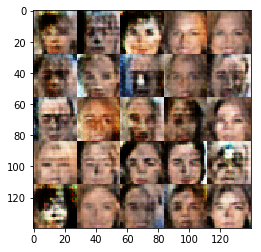

Epoch 1/1... Batch 1210... Discriminator Loss: 1.5687... Generator Loss: 0.4214
Epoch 1/1... Batch 1220... Discriminator Loss: 1.4076... Generator Loss: 0.6658
Epoch 1/1... Batch 1230... Discriminator Loss: 1.0819... Generator Loss: 1.1567
Epoch 1/1... Batch 1240... Discriminator Loss: 1.4543... Generator Loss: 0.7389
Epoch 1/1... Batch 1250... Discriminator Loss: 1.1643... Generator Loss: 0.9740
Epoch 1/1... Batch 1260... Discriminator Loss: 2.3765... Generator Loss: 2.1043
Epoch 1/1... Batch 1270... Discriminator Loss: 1.1670... Generator Loss: 0.7737
Epoch 1/1... Batch 1280... Discriminator Loss: 1.2276... Generator Loss: 0.8888
Epoch 1/1... Batch 1290... Discriminator Loss: 1.2896... Generator Loss: 0.8449
Epoch 1/1... Batch 1300... Discriminator Loss: 1.2243... Generator Loss: 0.6973


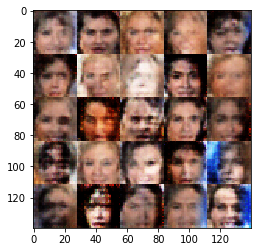

Epoch 1/1... Batch 1310... Discriminator Loss: 1.0315... Generator Loss: 1.4520
Epoch 1/1... Batch 1320... Discriminator Loss: 1.0734... Generator Loss: 1.2958
Epoch 1/1... Batch 1330... Discriminator Loss: 0.9642... Generator Loss: 1.2361
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0972... Generator Loss: 1.4648
Epoch 1/1... Batch 1350... Discriminator Loss: 0.6412... Generator Loss: 2.4610
Epoch 1/1... Batch 1360... Discriminator Loss: 1.0402... Generator Loss: 0.8190
Epoch 1/1... Batch 1370... Discriminator Loss: 1.5420... Generator Loss: 0.4773
Epoch 1/1... Batch 1380... Discriminator Loss: 1.3646... Generator Loss: 0.9145
Epoch 1/1... Batch 1390... Discriminator Loss: 1.0555... Generator Loss: 0.9483
Epoch 1/1... Batch 1400... Discriminator Loss: 1.1636... Generator Loss: 1.1887


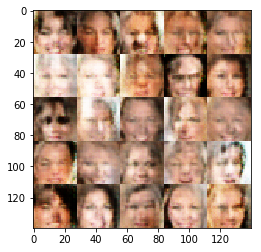

Epoch 1/1... Batch 1410... Discriminator Loss: 1.4624... Generator Loss: 0.7599
Epoch 1/1... Batch 1420... Discriminator Loss: 1.1538... Generator Loss: 0.7730
Epoch 1/1... Batch 1430... Discriminator Loss: 1.0792... Generator Loss: 0.9600
Epoch 1/1... Batch 1440... Discriminator Loss: 1.2417... Generator Loss: 0.7763
Epoch 1/1... Batch 1450... Discriminator Loss: 1.2978... Generator Loss: 0.6983
Epoch 1/1... Batch 1460... Discriminator Loss: 0.8370... Generator Loss: 1.3367
Epoch 1/1... Batch 1470... Discriminator Loss: 0.7523... Generator Loss: 1.5371
Epoch 1/1... Batch 1480... Discriminator Loss: 1.5040... Generator Loss: 1.0322
Epoch 1/1... Batch 1490... Discriminator Loss: 1.0704... Generator Loss: 0.9676
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2526... Generator Loss: 0.7658


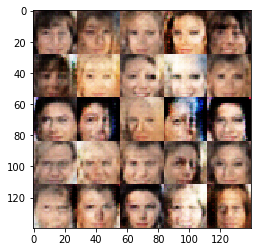

Epoch 1/1... Batch 1510... Discriminator Loss: 1.2309... Generator Loss: 0.8660
Epoch 1/1... Batch 1520... Discriminator Loss: 1.3670... Generator Loss: 0.4952
Epoch 1/1... Batch 1530... Discriminator Loss: 1.1635... Generator Loss: 0.6914
Epoch 1/1... Batch 1540... Discriminator Loss: 1.1418... Generator Loss: 0.8205
Epoch 1/1... Batch 1550... Discriminator Loss: 1.0096... Generator Loss: 1.0480
Epoch 1/1... Batch 1560... Discriminator Loss: 1.0800... Generator Loss: 0.9324
Epoch 1/1... Batch 1570... Discriminator Loss: 1.2352... Generator Loss: 0.6982
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1435... Generator Loss: 0.7687
Epoch 1/1... Batch 1590... Discriminator Loss: 1.1435... Generator Loss: 0.8485
Epoch 1/1... Batch 1600... Discriminator Loss: 1.1899... Generator Loss: 1.6931


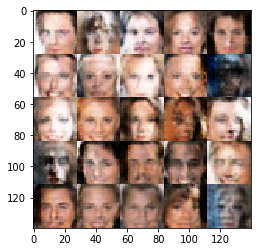

Epoch 1/1... Batch 1610... Discriminator Loss: 1.0965... Generator Loss: 1.0797
Epoch 1/1... Batch 1620... Discriminator Loss: 0.9695... Generator Loss: 0.9057
Epoch 1/1... Batch 1630... Discriminator Loss: 1.2449... Generator Loss: 1.1398
Epoch 1/1... Batch 1640... Discriminator Loss: 1.2990... Generator Loss: 1.3488
Epoch 1/1... Batch 1650... Discriminator Loss: 1.4673... Generator Loss: 1.0422
Epoch 1/1... Batch 1660... Discriminator Loss: 1.1362... Generator Loss: 0.7936
Epoch 1/1... Batch 1670... Discriminator Loss: 1.2059... Generator Loss: 0.9109
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4105... Generator Loss: 0.5281
Epoch 1/1... Batch 1690... Discriminator Loss: 1.2860... Generator Loss: 1.7304
Epoch 1/1... Batch 1700... Discriminator Loss: 1.1906... Generator Loss: 0.9019


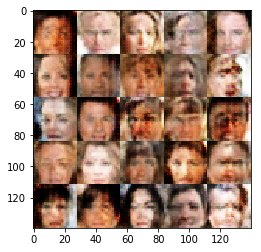

Epoch 1/1... Batch 1710... Discriminator Loss: 1.4078... Generator Loss: 0.5142
Epoch 1/1... Batch 1720... Discriminator Loss: 1.1429... Generator Loss: 0.9446
Epoch 1/1... Batch 1730... Discriminator Loss: 1.3404... Generator Loss: 1.3824
Epoch 1/1... Batch 1740... Discriminator Loss: 1.3088... Generator Loss: 0.8185
Epoch 1/1... Batch 1750... Discriminator Loss: 1.3078... Generator Loss: 0.5433
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1476... Generator Loss: 1.0912
Epoch 1/1... Batch 1770... Discriminator Loss: 1.4085... Generator Loss: 0.5621
Epoch 1/1... Batch 1780... Discriminator Loss: 1.2316... Generator Loss: 0.9346
Epoch 1/1... Batch 1790... Discriminator Loss: 1.1786... Generator Loss: 0.9852
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0809... Generator Loss: 0.7586


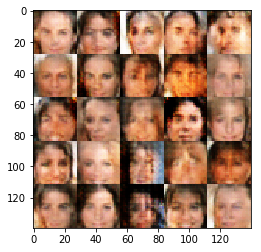

Epoch 1/1... Batch 1810... Discriminator Loss: 1.3046... Generator Loss: 1.1160
Epoch 1/1... Batch 1820... Discriminator Loss: 1.2607... Generator Loss: 1.4305
Epoch 1/1... Batch 1830... Discriminator Loss: 1.1533... Generator Loss: 1.0021
Epoch 1/1... Batch 1840... Discriminator Loss: 1.1481... Generator Loss: 0.8105
Epoch 1/1... Batch 1850... Discriminator Loss: 1.2013... Generator Loss: 0.8331
Epoch 1/1... Batch 1860... Discriminator Loss: 0.9403... Generator Loss: 1.2739
Epoch 1/1... Batch 1870... Discriminator Loss: 0.9588... Generator Loss: 0.9068
Epoch 1/1... Batch 1880... Discriminator Loss: 1.3609... Generator Loss: 1.8045
Epoch 1/1... Batch 1890... Discriminator Loss: 1.3030... Generator Loss: 0.9059
Epoch 1/1... Batch 1900... Discriminator Loss: 1.1330... Generator Loss: 0.7778


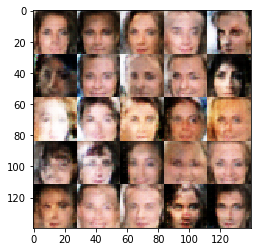

Epoch 1/1... Batch 1910... Discriminator Loss: 1.0985... Generator Loss: 1.0023
Epoch 1/1... Batch 1920... Discriminator Loss: 1.3002... Generator Loss: 0.8729
Epoch 1/1... Batch 1930... Discriminator Loss: 0.9950... Generator Loss: 0.8274
Epoch 1/1... Batch 1940... Discriminator Loss: 1.1299... Generator Loss: 1.0830
Epoch 1/1... Batch 1950... Discriminator Loss: 1.2174... Generator Loss: 0.8041
Epoch 1/1... Batch 1960... Discriminator Loss: 1.2003... Generator Loss: 1.1413
Epoch 1/1... Batch 1970... Discriminator Loss: 1.2568... Generator Loss: 0.9294
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1209... Generator Loss: 0.8906
Epoch 1/1... Batch 1990... Discriminator Loss: 1.1255... Generator Loss: 0.7163
Epoch 1/1... Batch 2000... Discriminator Loss: 1.5102... Generator Loss: 0.4647


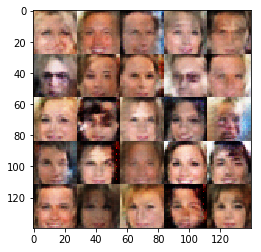

Epoch 1/1... Batch 2010... Discriminator Loss: 0.9267... Generator Loss: 1.5109
Epoch 1/1... Batch 2020... Discriminator Loss: 1.2873... Generator Loss: 1.1069
Epoch 1/1... Batch 2030... Discriminator Loss: 1.2217... Generator Loss: 0.9680
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1826... Generator Loss: 0.8084
Epoch 1/1... Batch 2050... Discriminator Loss: 1.3378... Generator Loss: 0.8566
Epoch 1/1... Batch 2060... Discriminator Loss: 1.3435... Generator Loss: 1.0901
Epoch 1/1... Batch 2070... Discriminator Loss: 1.2138... Generator Loss: 0.6708
Epoch 1/1... Batch 2080... Discriminator Loss: 1.1827... Generator Loss: 1.1980
Epoch 1/1... Batch 2090... Discriminator Loss: 1.1744... Generator Loss: 0.8710
Epoch 1/1... Batch 2100... Discriminator Loss: 1.1020... Generator Loss: 1.8944


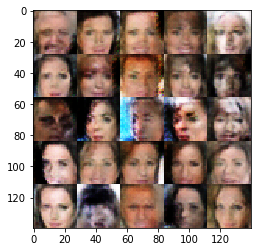

Epoch 1/1... Batch 2110... Discriminator Loss: 1.5705... Generator Loss: 0.4250
Epoch 1/1... Batch 2120... Discriminator Loss: 1.2066... Generator Loss: 0.8053
Epoch 1/1... Batch 2130... Discriminator Loss: 1.3103... Generator Loss: 0.6163
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1471... Generator Loss: 0.8888
Epoch 1/1... Batch 2150... Discriminator Loss: 0.9567... Generator Loss: 1.2806
Epoch 1/1... Batch 2160... Discriminator Loss: 1.4067... Generator Loss: 0.5647
Epoch 1/1... Batch 2170... Discriminator Loss: 1.1877... Generator Loss: 1.1036
Epoch 1/1... Batch 2180... Discriminator Loss: 1.1694... Generator Loss: 0.9852
Epoch 1/1... Batch 2190... Discriminator Loss: 1.1608... Generator Loss: 0.7781
Epoch 1/1... Batch 2200... Discriminator Loss: 1.3314... Generator Loss: 0.5342


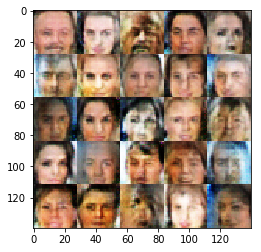

Epoch 1/1... Batch 2210... Discriminator Loss: 1.2751... Generator Loss: 0.8352
Epoch 1/1... Batch 2220... Discriminator Loss: 1.2165... Generator Loss: 0.8382
Epoch 1/1... Batch 2230... Discriminator Loss: 1.2266... Generator Loss: 0.8599
Epoch 1/1... Batch 2240... Discriminator Loss: 0.9976... Generator Loss: 1.1060
Epoch 1/1... Batch 2250... Discriminator Loss: 1.1418... Generator Loss: 0.8064
Epoch 1/1... Batch 2260... Discriminator Loss: 1.1341... Generator Loss: 1.1834
Epoch 1/1... Batch 2270... Discriminator Loss: 1.4723... Generator Loss: 0.4366
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2391... Generator Loss: 1.0335
Epoch 1/1... Batch 2290... Discriminator Loss: 1.1539... Generator Loss: 1.1010
Epoch 1/1... Batch 2300... Discriminator Loss: 1.2228... Generator Loss: 1.2081


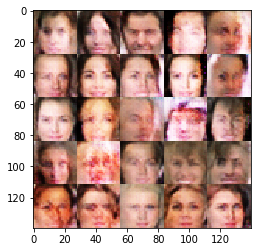

Epoch 1/1... Batch 2310... Discriminator Loss: 0.9172... Generator Loss: 1.1784
Epoch 1/1... Batch 2320... Discriminator Loss: 1.3368... Generator Loss: 0.7706
Epoch 1/1... Batch 2330... Discriminator Loss: 1.2510... Generator Loss: 0.6777
Epoch 1/1... Batch 2340... Discriminator Loss: 1.2801... Generator Loss: 0.7843
Epoch 1/1... Batch 2350... Discriminator Loss: 1.1457... Generator Loss: 0.9093
Epoch 1/1... Batch 2360... Discriminator Loss: 1.1180... Generator Loss: 1.9182
Epoch 1/1... Batch 2370... Discriminator Loss: 1.0057... Generator Loss: 1.6405
Epoch 1/1... Batch 2380... Discriminator Loss: 1.3610... Generator Loss: 0.5509
Epoch 1/1... Batch 2390... Discriminator Loss: 1.2826... Generator Loss: 0.6815
Epoch 1/1... Batch 2400... Discriminator Loss: 1.1158... Generator Loss: 1.1255


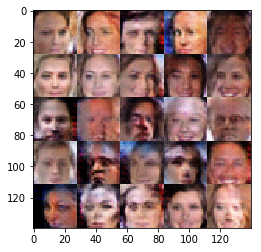

Epoch 1/1... Batch 2410... Discriminator Loss: 1.3115... Generator Loss: 0.6656
Epoch 1/1... Batch 2420... Discriminator Loss: 1.1280... Generator Loss: 0.7686
Epoch 1/1... Batch 2430... Discriminator Loss: 1.0937... Generator Loss: 0.7709
Epoch 1/1... Batch 2440... Discriminator Loss: 1.3906... Generator Loss: 0.5396
Epoch 1/1... Batch 2450... Discriminator Loss: 0.9960... Generator Loss: 1.1247
Epoch 1/1... Batch 2460... Discriminator Loss: 1.4778... Generator Loss: 0.8827
Epoch 1/1... Batch 2470... Discriminator Loss: 1.3041... Generator Loss: 0.7156
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1075... Generator Loss: 0.9717
Epoch 1/1... Batch 2490... Discriminator Loss: 1.2492... Generator Loss: 0.8118
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2385... Generator Loss: 0.9345


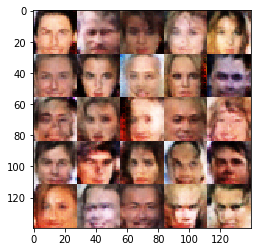

Epoch 1/1... Batch 2510... Discriminator Loss: 1.0254... Generator Loss: 0.9966
Epoch 1/1... Batch 2520... Discriminator Loss: 1.1918... Generator Loss: 0.9297
Epoch 1/1... Batch 2530... Discriminator Loss: 1.2867... Generator Loss: 0.6232
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1069... Generator Loss: 1.7408
Epoch 1/1... Batch 2550... Discriminator Loss: 1.1280... Generator Loss: 0.7568
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2098... Generator Loss: 0.9690
Epoch 1/1... Batch 2570... Discriminator Loss: 1.3110... Generator Loss: 0.6779
Epoch 1/1... Batch 2580... Discriminator Loss: 1.2760... Generator Loss: 0.8314
Epoch 1/1... Batch 2590... Discriminator Loss: 1.6369... Generator Loss: 0.5850
Epoch 1/1... Batch 2600... Discriminator Loss: 1.3143... Generator Loss: 1.0583


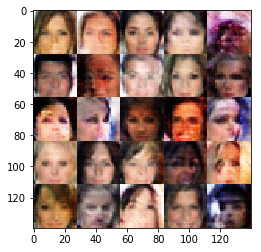

Epoch 1/1... Batch 2610... Discriminator Loss: 1.3469... Generator Loss: 1.0068
Epoch 1/1... Batch 2620... Discriminator Loss: 1.2168... Generator Loss: 0.9443
Epoch 1/1... Batch 2630... Discriminator Loss: 1.2230... Generator Loss: 0.9746
Epoch 1/1... Batch 2640... Discriminator Loss: 1.1856... Generator Loss: 1.0146
Epoch 1/1... Batch 2650... Discriminator Loss: 1.2359... Generator Loss: 0.8858
Epoch 1/1... Batch 2660... Discriminator Loss: 1.3014... Generator Loss: 1.0537
Epoch 1/1... Batch 2670... Discriminator Loss: 1.3098... Generator Loss: 1.3212
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1940... Generator Loss: 0.7274
Epoch 1/1... Batch 2690... Discriminator Loss: 1.2657... Generator Loss: 0.8128
Epoch 1/1... Batch 2700... Discriminator Loss: 1.2327... Generator Loss: 1.0027


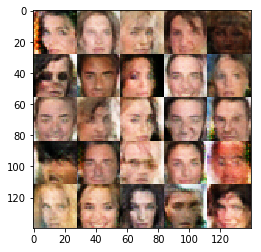

Epoch 1/1... Batch 2710... Discriminator Loss: 1.4951... Generator Loss: 0.4487
Epoch 1/1... Batch 2720... Discriminator Loss: 1.1623... Generator Loss: 0.7718
Epoch 1/1... Batch 2730... Discriminator Loss: 1.3045... Generator Loss: 1.2331
Epoch 1/1... Batch 2740... Discriminator Loss: 1.2222... Generator Loss: 0.7733
Epoch 1/1... Batch 2750... Discriminator Loss: 1.1877... Generator Loss: 0.9732
Epoch 1/1... Batch 2760... Discriminator Loss: 1.1193... Generator Loss: 0.7867
Epoch 1/1... Batch 2770... Discriminator Loss: 1.3982... Generator Loss: 0.7270
Epoch 1/1... Batch 2780... Discriminator Loss: 1.2243... Generator Loss: 0.6373
Epoch 1/1... Batch 2790... Discriminator Loss: 1.4393... Generator Loss: 0.6224
Epoch 1/1... Batch 2800... Discriminator Loss: 1.1092... Generator Loss: 0.9205


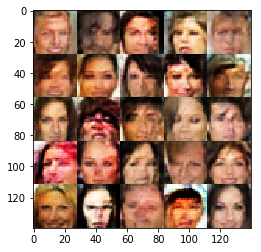

Epoch 1/1... Batch 2810... Discriminator Loss: 1.2541... Generator Loss: 0.7597
Epoch 1/1... Batch 2820... Discriminator Loss: 1.1256... Generator Loss: 0.8496
Epoch 1/1... Batch 2830... Discriminator Loss: 1.3013... Generator Loss: 1.2905
Epoch 1/1... Batch 2840... Discriminator Loss: 1.1505... Generator Loss: 1.0426
Epoch 1/1... Batch 2850... Discriminator Loss: 1.1527... Generator Loss: 0.9592
Epoch 1/1... Batch 2860... Discriminator Loss: 1.3689... Generator Loss: 0.6097
Epoch 1/1... Batch 2870... Discriminator Loss: 1.1487... Generator Loss: 0.8761
Epoch 1/1... Batch 2880... Discriminator Loss: 1.2261... Generator Loss: 0.6629
Epoch 1/1... Batch 2890... Discriminator Loss: 1.3680... Generator Loss: 0.9086
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1312... Generator Loss: 0.8506


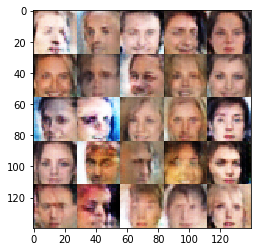

Epoch 1/1... Batch 2910... Discriminator Loss: 1.2644... Generator Loss: 0.7602
Epoch 1/1... Batch 2920... Discriminator Loss: 1.2613... Generator Loss: 1.1136
Epoch 1/1... Batch 2930... Discriminator Loss: 1.3379... Generator Loss: 0.7777
Epoch 1/1... Batch 2940... Discriminator Loss: 1.4782... Generator Loss: 0.4757
Epoch 1/1... Batch 2950... Discriminator Loss: 1.2444... Generator Loss: 0.8377
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2544... Generator Loss: 0.8917
Epoch 1/1... Batch 2970... Discriminator Loss: 1.2204... Generator Loss: 0.7411
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1669... Generator Loss: 0.7922
Epoch 1/1... Batch 2990... Discriminator Loss: 1.2759... Generator Loss: 0.7949
Epoch 1/1... Batch 3000... Discriminator Loss: 1.2240... Generator Loss: 0.7843


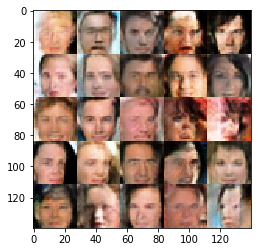

Epoch 1/1... Batch 3010... Discriminator Loss: 1.3138... Generator Loss: 0.7190
Epoch 1/1... Batch 3020... Discriminator Loss: 1.3624... Generator Loss: 0.5413
Epoch 1/1... Batch 3030... Discriminator Loss: 1.2852... Generator Loss: 1.0754
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2290... Generator Loss: 0.9054
Epoch 1/1... Batch 3050... Discriminator Loss: 1.2761... Generator Loss: 0.7546
Epoch 1/1... Batch 3060... Discriminator Loss: 1.2644... Generator Loss: 1.0742
Epoch 1/1... Batch 3070... Discriminator Loss: 1.1769... Generator Loss: 0.8621
Epoch 1/1... Batch 3080... Discriminator Loss: 1.3534... Generator Loss: 1.2879
Epoch 1/1... Batch 3090... Discriminator Loss: 1.3005... Generator Loss: 0.7649
Epoch 1/1... Batch 3100... Discriminator Loss: 1.2454... Generator Loss: 0.7018


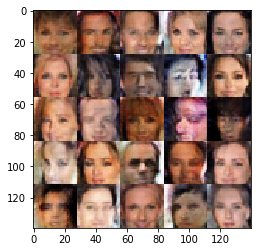

Epoch 1/1... Batch 3110... Discriminator Loss: 1.2410... Generator Loss: 0.8771
Epoch 1/1... Batch 3120... Discriminator Loss: 1.1943... Generator Loss: 0.8563
Epoch 1/1... Batch 3130... Discriminator Loss: 1.2760... Generator Loss: 0.6893
Epoch 1/1... Batch 3140... Discriminator Loss: 1.2136... Generator Loss: 0.9223
Epoch 1/1... Batch 3150... Discriminator Loss: 1.2664... Generator Loss: 0.8170
Epoch 1/1... Batch 3160... Discriminator Loss: 1.6036... Generator Loss: 0.3764


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.